# ****Model Evaluation with Comparative Analysis****

In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, precision_score,
    f1_score, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, classification_report
)

sns.set_theme(style="whitegrid")

# Paths
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
DATA_PATH = os.path.join(BASE_DIR, 'stroke-prediction-project', 'data', 'processed', 'cleaned_dataset.csv')
REPORT_DIR = os.path.join(BASE_DIR, 'stroke-prediction-project', 'reports')
os.makedirs(REPORT_DIR, exist_ok=True)

In [2]:
def model_evaluator(model, model_name, X_test, y_test):
    
    report_dir=REPORT_DIR
    # Train and predict
    y_pred = model.predict(X_test)
    # Check if the model has predict_proba method
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # In case model doesn't have predict_proba, you may use predict instead
        y_proba = model.predict(X_test)  # Use predicted labels directly (for metrics like AUC)


    # Metrics
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)

    print("\n" + "=" * 60)
    print(f"{model_name.upper()} PERFORMANCE ON TEST SET".center(60))
    print("=" * 60)

    metrics_df = pd.DataFrame({
        'Accuracy': [accuracy],
        'Sensitivity/Recall': [recall],
        'Specificity': [specificity],
        'F1 Score': [f1],
        'Precision': [precision],
        'ROC AUC': [roc_auc],
        'Average Precision': [avg_precision]
    })
    display(metrics_df.style.hide(axis='index'))

    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["No Stroke", "Stroke"]))
    print("=" * 60)

    
    # Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    cm_path = os.path.join(report_dir, f"{model_name}_confusion_matrix.png")
    plt.savefig(cm_path, dpi=300)
    plt.show()

    # Confusion Matrix (Normalized)
    plt.figure(figsize=(6, 5))
    cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['No Stroke', 'Stroke'],
                yticklabels=['No Stroke', 'Stroke'])
    plt.title('Confusion Matrix (Normalized)', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    cm_norm_path = os.path.join(report_dir, f"{model_name}_confusion_matrix.png")
    plt.savefig(cm_norm_path, dpi=300)
    plt.show()

    # ROC and PR Curves
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)

    plt.figure(figsize=(12, 4))

    # ROC
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    # PR
    plt.subplot(1, 2, 2)
    plt.step(recall_curve, precision_curve, where='post', label=f'AP = {avg_precision:.2f}')
    plt.fill_between(recall_curve, precision_curve, alpha=0.3)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')

    plt.tight_layout()
    roc_pr_path = os.path.join(report_dir, f"{model_name}_performance_overview.png")
    plt.savefig(roc_pr_path, dpi=300)
    plt.show()

    # Sensitivity & Specificity Bar Plot
    plt.figure(figsize=(4, 3))
    metrics = ['Sensitivity\n(Recall)', 'Specificity']
    values = [recall, specificity]
    colors = ['#ff9999', '#66b3ff']

    plt.bar(metrics, values, color=colors)
    plt.ylim(0, 1.0)
    plt.title('Sensitivity and Specificity', fontsize=12, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

    bar_path = os.path.join(report_dir, f"{model_name}_sensitivity_specificity.png")
    plt.tight_layout()
    plt.savefig(bar_path, dpi=300)
    plt.show()

    print(f"\nPerformance plots saved to:\n- {roc_pr_path}\n- {bar_path}")


In [3]:
# Load and prepare data
df = pd.read_csv(DATA_PATH)
X = df.drop(columns=['stroke'])
y = df['stroke']

In [4]:

X_train = pd.read_csv(os.path.join(BASE_DIR, 'stroke-prediction-project', 'data', 'processed', 'X_train_resampled.csv'))
y_train = pd.read_csv(os.path.join(BASE_DIR, 'stroke-prediction-project', 'data', 'processed', 'y_train_resampled.csv'))
X_test = pd.read_csv(os.path.join(BASE_DIR, 'stroke-prediction-project', 'data', 'processed', 'X_test_processed.csv'))
y_test = pd.read_csv(os.path.join(BASE_DIR, 'stroke-prediction-project', 'data', 'processed', 'y_test.csv'))

1. **k-NN Classifier Model**


                KNN PERFORMANCE ON TEST SET                 


Accuracy,Sensitivity/Recall,Specificity,F1 Score,Precision,ROC AUC,Average Precision
0.770385,0.453333,0.786694,0.161905,0.098551,0.664947,0.087949



Detailed Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.97      0.79      0.87      1458
      Stroke       0.10      0.45      0.16        75

    accuracy                           0.77      1533
   macro avg       0.53      0.62      0.51      1533
weighted avg       0.92      0.77      0.83      1533



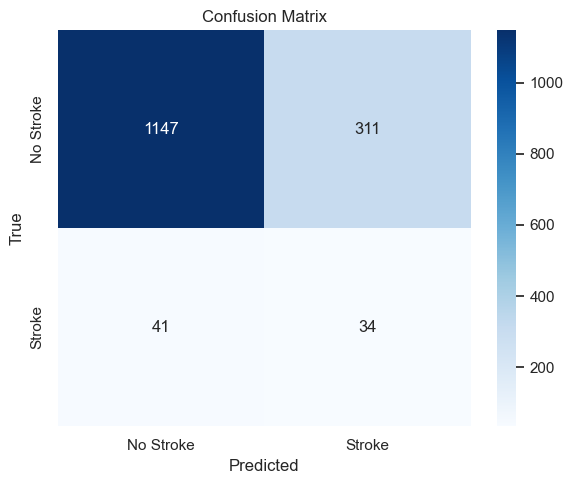

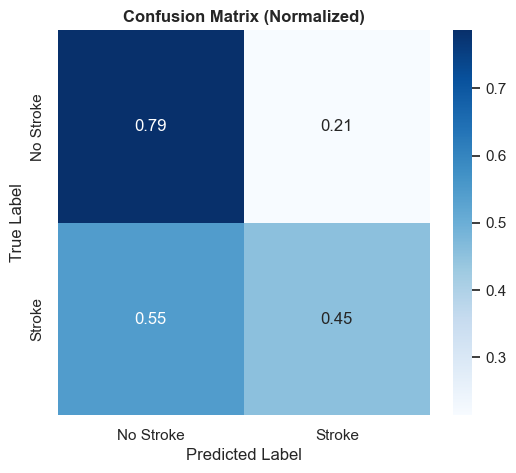

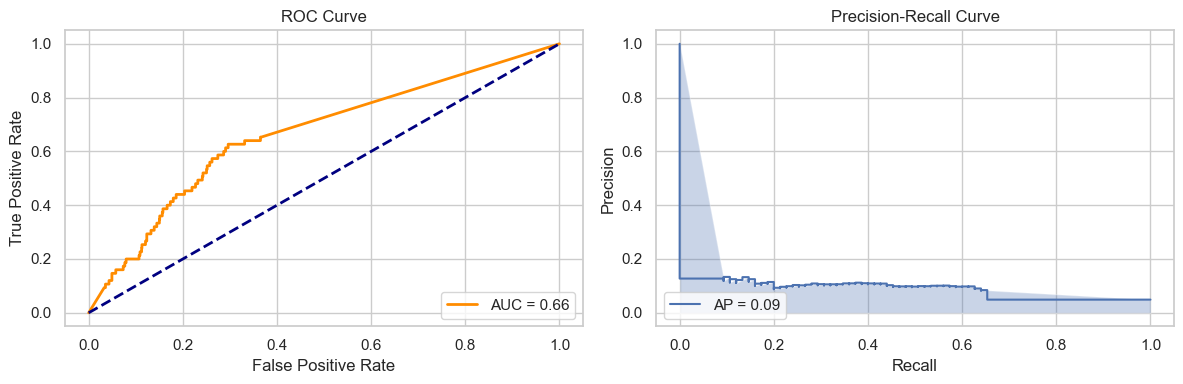

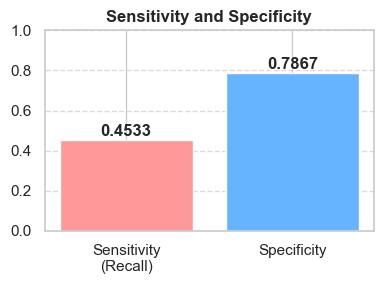


Performance plots saved to:
- /Users/anuranjani/Desktop/my_projects/stroke-prediction-model/stroke-prediction-project/reports/knn_performance_overview.png
- /Users/anuranjani/Desktop/my_projects/stroke-prediction-model/stroke-prediction-project/reports/knn_sensitivity_specificity.png


In [5]:
MODEL_PATH = os.path.join(BASE_DIR, 'stroke-prediction-project', 'src', 'models', 'knn_model.pkl')


# Step 1: Load model
with open(MODEL_PATH, 'rb') as file:
    knn_model = pickle.load(file)
    
model_evaluator(knn_model, "knn", X_test, y_test)


2. **Bayesian Learning (Gaussian Naive Bayes) Model**


              BAYESIAN PERFORMANCE ON TEST SET              


Accuracy,Sensitivity/Recall,Specificity,F1 Score,Precision,ROC AUC,Average Precision
0.615134,0.800000,0.605624,0.169014,0.094488,0.773374,0.173035



Detailed Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.98      0.61      0.75      1458
      Stroke       0.09      0.80      0.17        75

    accuracy                           0.62      1533
   macro avg       0.54      0.70      0.46      1533
weighted avg       0.94      0.62      0.72      1533



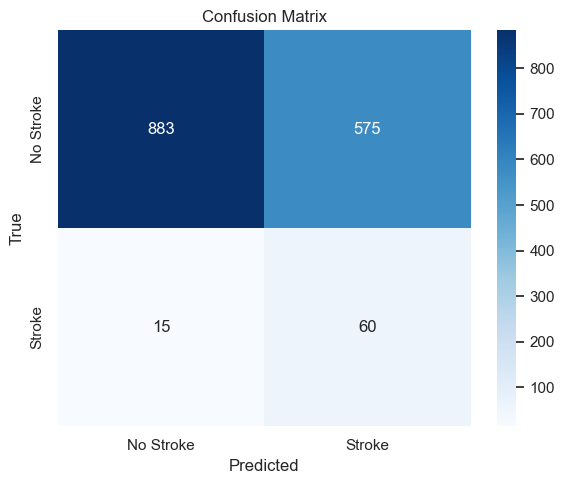

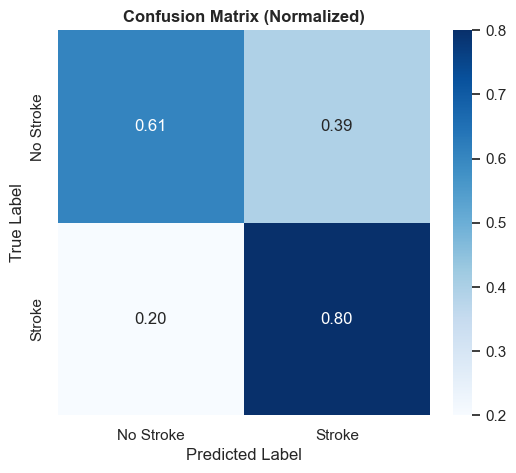

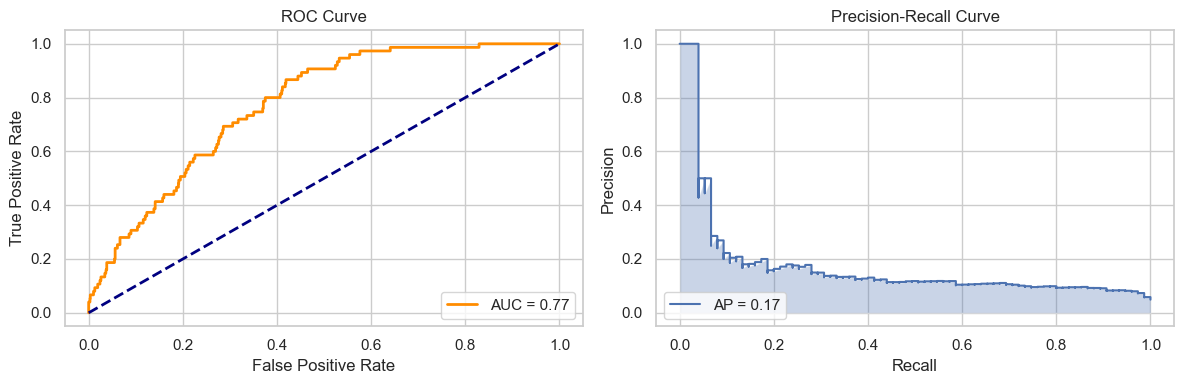

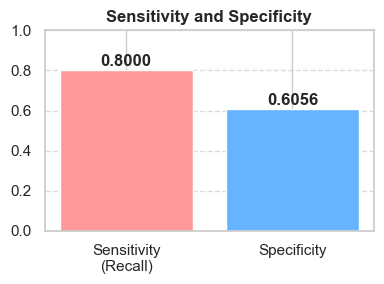


Performance plots saved to:
- /Users/anuranjani/Desktop/my_projects/stroke-prediction-model/stroke-prediction-project/reports/bayesian_performance_overview.png
- /Users/anuranjani/Desktop/my_projects/stroke-prediction-model/stroke-prediction-project/reports/bayesian_sensitivity_specificity.png


In [6]:
MODEL_PATH = os.path.join(BASE_DIR, 'stroke-prediction-project', 'src', 'models', 'bayesian_model.pkl')


# Step 1: Load model
with open(MODEL_PATH, 'rb') as file:
    bayesian_model = pickle.load(file)
    
model_evaluator(bayesian_model, "bayesian", X_test, y_test)


3. **Single/Support Vector Machine (SVM) Model**


                SVM PERFORMANCE ON TEST SET                 


Accuracy,Sensitivity/Recall,Specificity,F1 Score,Precision,ROC AUC,Average Precision
0.902805,0.133333,0.942387,0.118343,0.106383,0.663484,0.091766



Detailed Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.95      0.94      0.95      1458
      Stroke       0.11      0.13      0.12        75

    accuracy                           0.90      1533
   macro avg       0.53      0.54      0.53      1533
weighted avg       0.91      0.90      0.91      1533



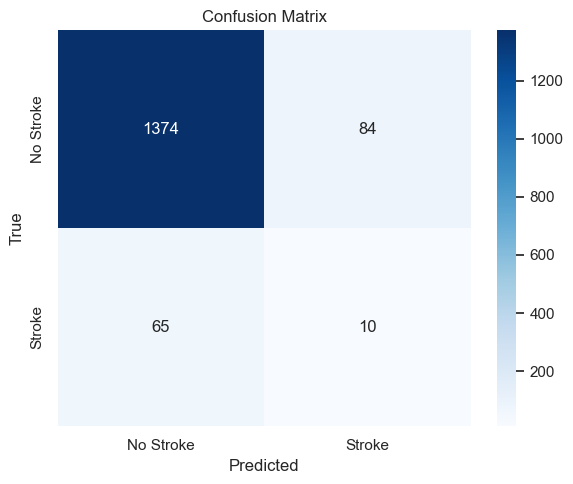

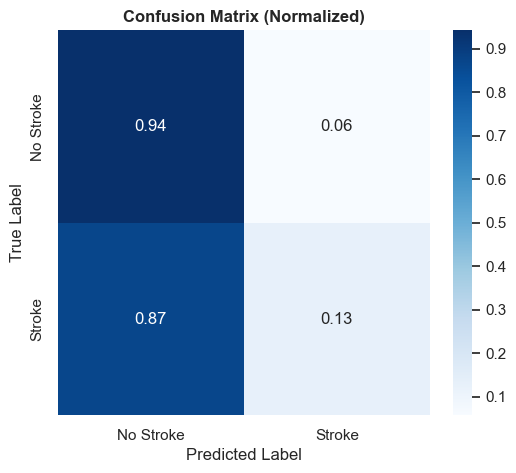

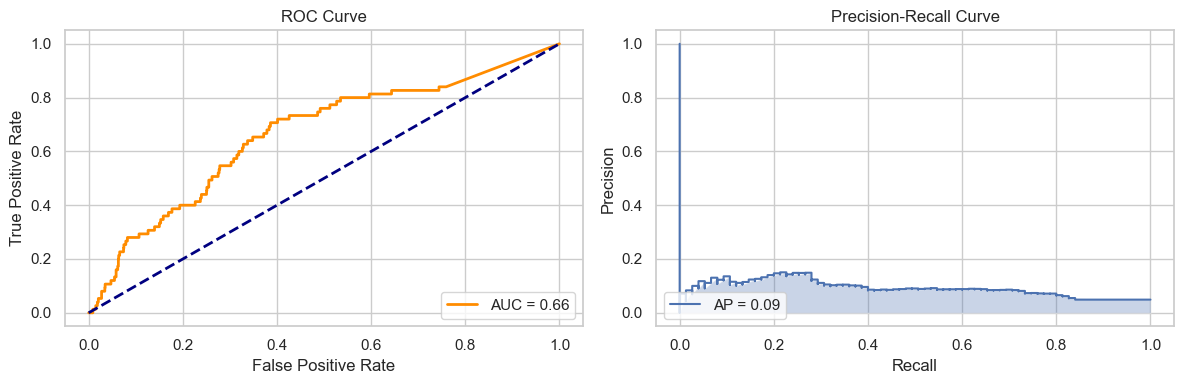

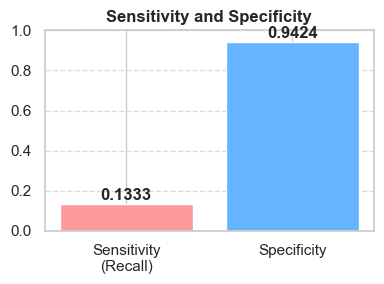


Performance plots saved to:
- /Users/anuranjani/Desktop/my_projects/stroke-prediction-model/stroke-prediction-project/reports/svm_performance_overview.png
- /Users/anuranjani/Desktop/my_projects/stroke-prediction-model/stroke-prediction-project/reports/svm_sensitivity_specificity.png


In [7]:
MODEL_PATH = os.path.join(BASE_DIR, 'stroke-prediction-project', 'src', 'models', 'svm_model.pkl')


# Step 1: Load model
with open(MODEL_PATH, 'rb') as file:
    svm_model = pickle.load(file)
    
model_evaluator(svm_model, "svm", X_test, y_test)


4. **Logistic Regression Model**


        LOGISTIC_REGRESSION PERFORMANCE ON TEST SET         


Accuracy,Sensitivity/Recall,Specificity,F1 Score,Precision,ROC AUC,Average Precision
0.858447,0.600000,0.871742,0.293160,0.193966,0.833214,0.217990



Detailed Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.98      0.87      0.92      1458
      Stroke       0.19      0.60      0.29        75

    accuracy                           0.86      1533
   macro avg       0.59      0.74      0.61      1533
weighted avg       0.94      0.86      0.89      1533



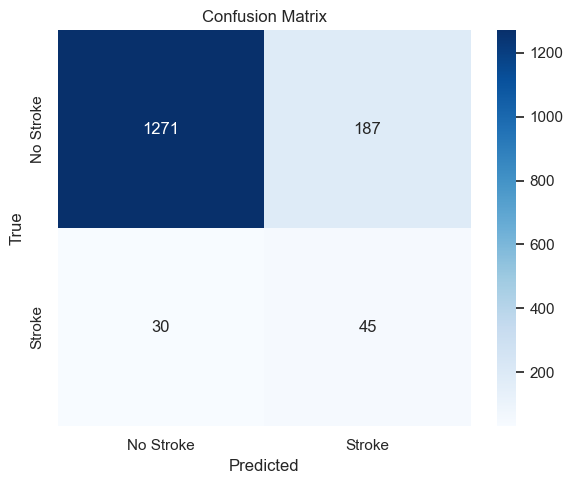

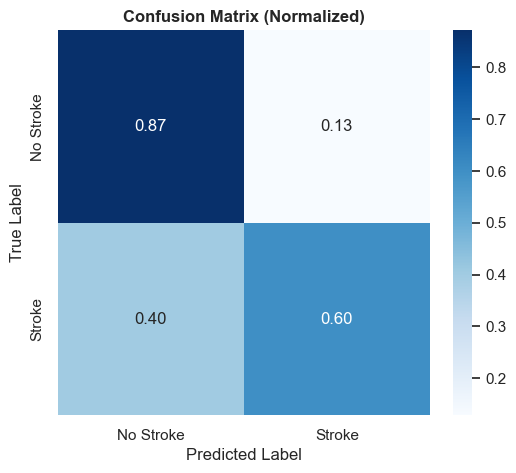

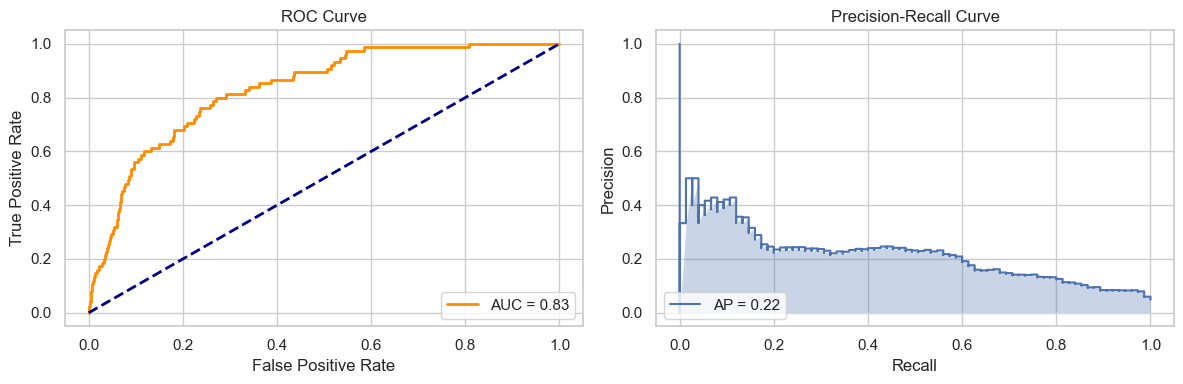

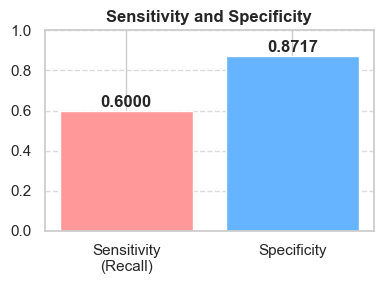


Performance plots saved to:
- /Users/anuranjani/Desktop/my_projects/stroke-prediction-model/stroke-prediction-project/reports/logistic_regression_performance_overview.png
- /Users/anuranjani/Desktop/my_projects/stroke-prediction-model/stroke-prediction-project/reports/logistic_regression_sensitivity_specificity.png


In [8]:
MODEL_PATH = os.path.join(BASE_DIR, 'stroke-prediction-project', 'src', 'models', 'logistic_regression_model.pkl')


# Step 1: Load model
with open(MODEL_PATH, 'rb') as file:
    logistic_regression_model = pickle.load(file)
    
model_evaluator(logistic_regression_model, "logistic_regression", X_test, y_test)


5. **Decision Tree Model**


           DECISION_TREE PERFORMANCE ON TEST SET            


Accuracy,Sensitivity/Recall,Specificity,F1 Score,Precision,ROC AUC,Average Precision
0.615786,0.813333,0.605624,0.171589,0.095912,0.721587,0.095352



Detailed Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.98      0.61      0.75      1458
      Stroke       0.10      0.81      0.17        75

    accuracy                           0.62      1533
   macro avg       0.54      0.71      0.46      1533
weighted avg       0.94      0.62      0.72      1533



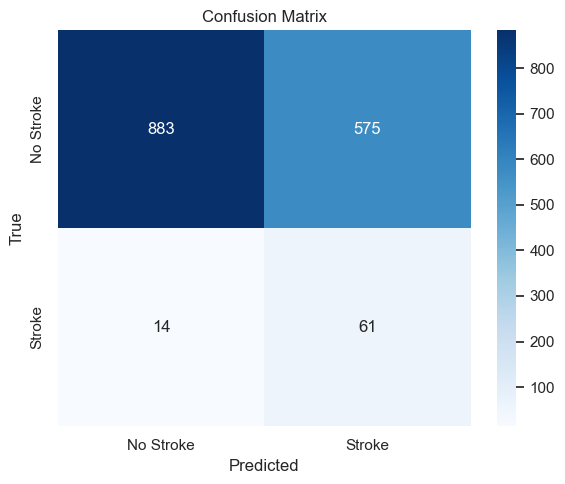

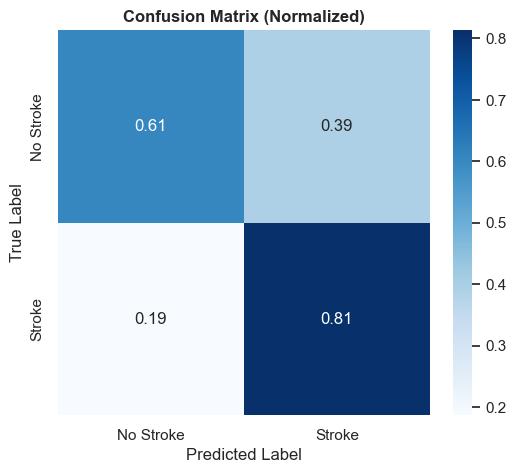

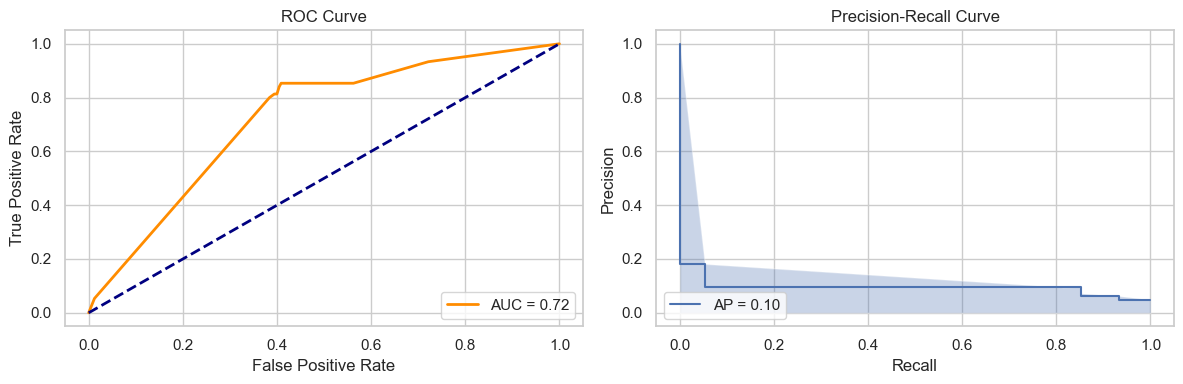

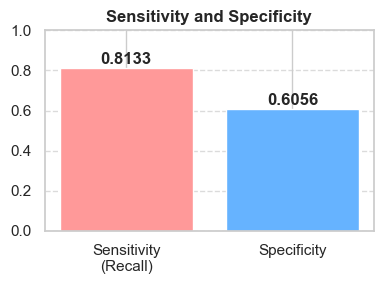


Performance plots saved to:
- /Users/anuranjani/Desktop/my_projects/stroke-prediction-model/stroke-prediction-project/reports/decision_tree_performance_overview.png
- /Users/anuranjani/Desktop/my_projects/stroke-prediction-model/stroke-prediction-project/reports/decision_tree_sensitivity_specificity.png


In [9]:
MODEL_PATH = os.path.join(BASE_DIR, 'stroke-prediction-project', 'src', 'models', 'decision_tree_model.pkl')


# Step 1: Load model
with open(MODEL_PATH, 'rb') as file:
    decision_tree_model = pickle.load(file)
    
model_evaluator(decision_tree_model, "decision_tree", X_test, y_test)


6. **Artificial Neural Network (ANN) / Multi-Level Perceptron (MLP)**


                ANN PERFORMANCE ON TEST SET                 


Accuracy,Sensitivity/Recall,Specificity,F1 Score,Precision,ROC AUC,Average Precision
0.893020,0.186667,0.929355,0.145833,0.119658,0.720704,0.122556



Detailed Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.96      0.93      0.94      1458
      Stroke       0.12      0.19      0.15        75

    accuracy                           0.89      1533
   macro avg       0.54      0.56      0.54      1533
weighted avg       0.92      0.89      0.90      1533



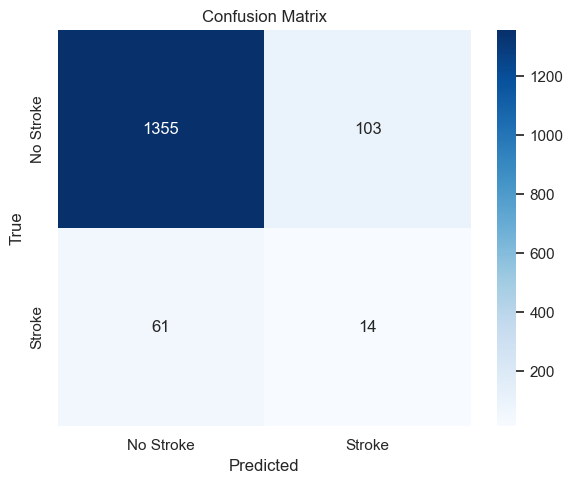

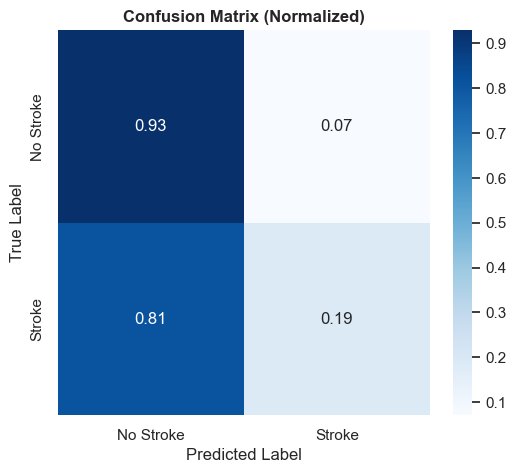

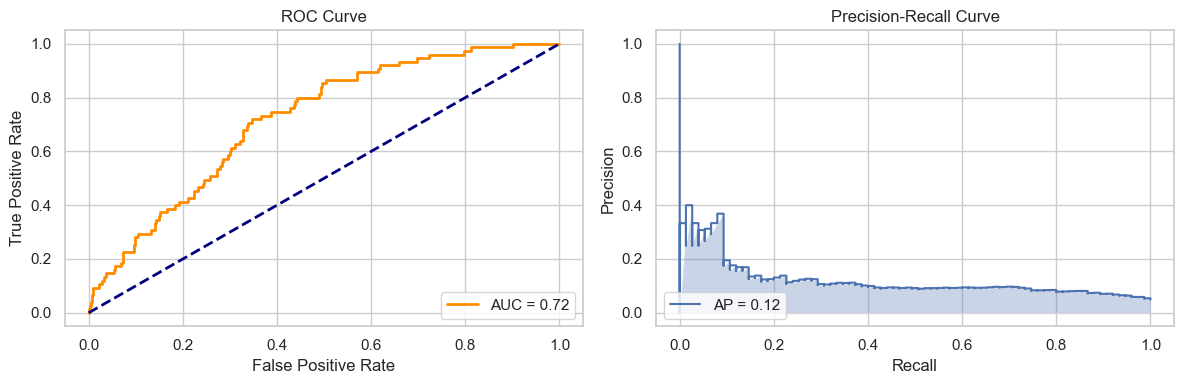

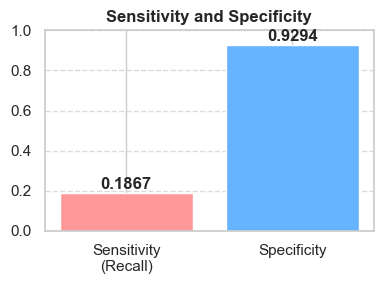


Performance plots saved to:
- /Users/anuranjani/Desktop/my_projects/stroke-prediction-model/stroke-prediction-project/reports/ANN_performance_overview.png
- /Users/anuranjani/Desktop/my_projects/stroke-prediction-model/stroke-prediction-project/reports/ANN_sensitivity_specificity.png


In [10]:
MODEL_PATH = os.path.join(BASE_DIR, 'stroke-prediction-project', 'src', 'models', 'ann_model.pkl')


# Step 1: Load model
with open(MODEL_PATH, 'rb') as file:
    ann_model = pickle.load(file)
    
model_evaluator(ann_model, "ANN", X_test, y_test)


7. **Random Forest**


           RANDOM_FOREST PERFORMANCE ON TEST SET            


Accuracy,Sensitivity/Recall,Specificity,F1 Score,Precision,ROC AUC,Average Precision
0.862361,0.533333,0.879287,0.274914,0.185185,0.812835,0.175379



Detailed Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.97      0.88      0.92      1458
      Stroke       0.19      0.53      0.27        75

    accuracy                           0.86      1533
   macro avg       0.58      0.71      0.60      1533
weighted avg       0.93      0.86      0.89      1533



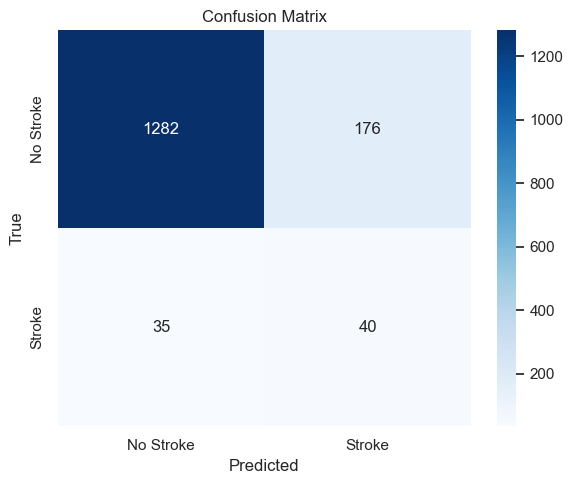

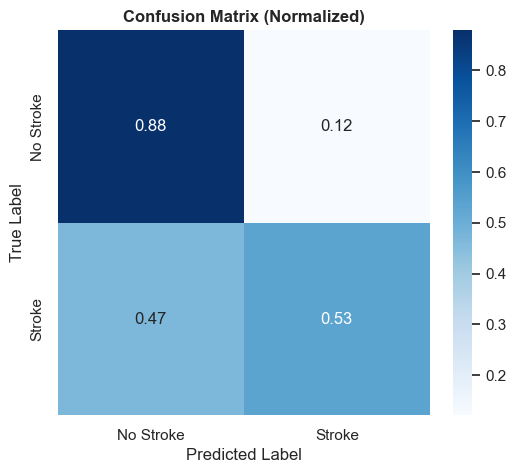

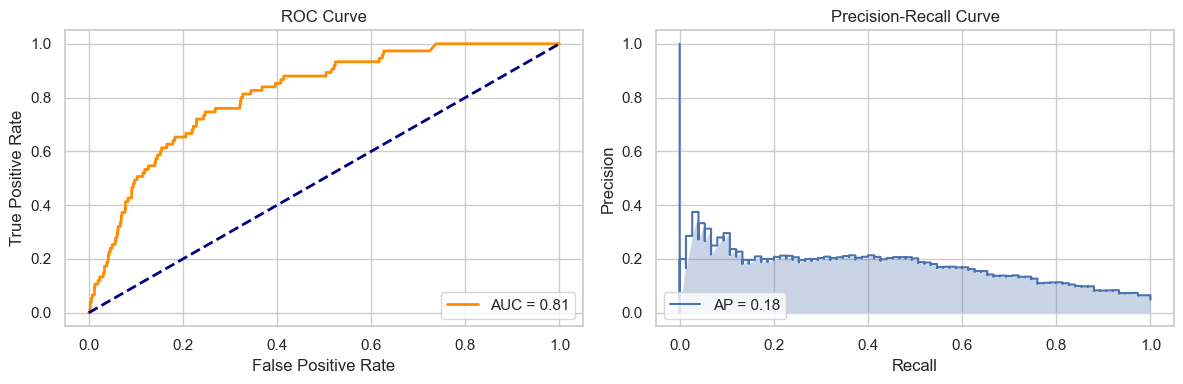

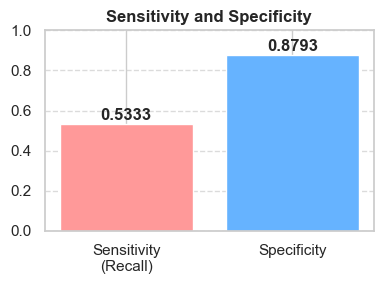


Performance plots saved to:
- /Users/anuranjani/Desktop/my_projects/stroke-prediction-model/stroke-prediction-project/reports/random_forest_performance_overview.png
- /Users/anuranjani/Desktop/my_projects/stroke-prediction-model/stroke-prediction-project/reports/random_forest_sensitivity_specificity.png


In [11]:
MODEL_PATH = os.path.join(BASE_DIR, 'stroke-prediction-project', 'src', 'models', 'rf_model.pkl')


# Step 1: Load model
with open(MODEL_PATH, 'rb') as file:
    rf_model = pickle.load(file)
    
model_evaluator(rf_model, "random_forest", X_test, y_test)


# **Now comparing how the models fair against each other....**

===== DETAILED MODEL ANALYSIS FOR STROKE PREDICTION =====

Model Performance Rankings:

General Hospital Screening:
  1. Logistic Regression (Score: 0.7086)
  2. Random Forest (Score: 0.6888)
  3. Bayesian (Score: 0.6158)
  4. Decision Tree (Score: 0.6119)
  5. ANN (Score: 0.6040)
  6. KNN (Score: 0.5881)
  7. SVM (Score: 0.5668)

High-Risk Patient Screening:
  1. Bayesian (Score: 0.8128)
  2. Decision Tree (Score: 0.8092)
  3. Logistic Regression (Score: 0.7479)
  4. Random Forest (Score: 0.7100)
  5. KNN (Score: 0.6296)
  6. ANN (Score: 0.5436)
  7. SVM (Score: 0.4805)

Limited Resource Setting:
  1. Logistic Regression (Score: 0.5941)
  2. Random Forest (Score: 0.5916)
  3. ANN (Score: 0.5852)
  4. SVM (Score: 0.5722)
  5. KNN (Score: 0.4960)
  6. Bayesian (Score: 0.4198)
  7. Decision Tree (Score: 0.4154)

Balanced Clinical Decision Support:
  1. Logistic Regression (Score: 0.5532)
  2. Random Forest (Score: 0.5339)
  3. ANN (Score: 0.4770)
  4. Bayesian (Score: 0.4404)
  5. SVM (S

/var/folders/2s/959hxcwj6w5fcykv3xt79td40000gn/T/ipykernel_31917/4256559217.py:341: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  cm_fig.show()


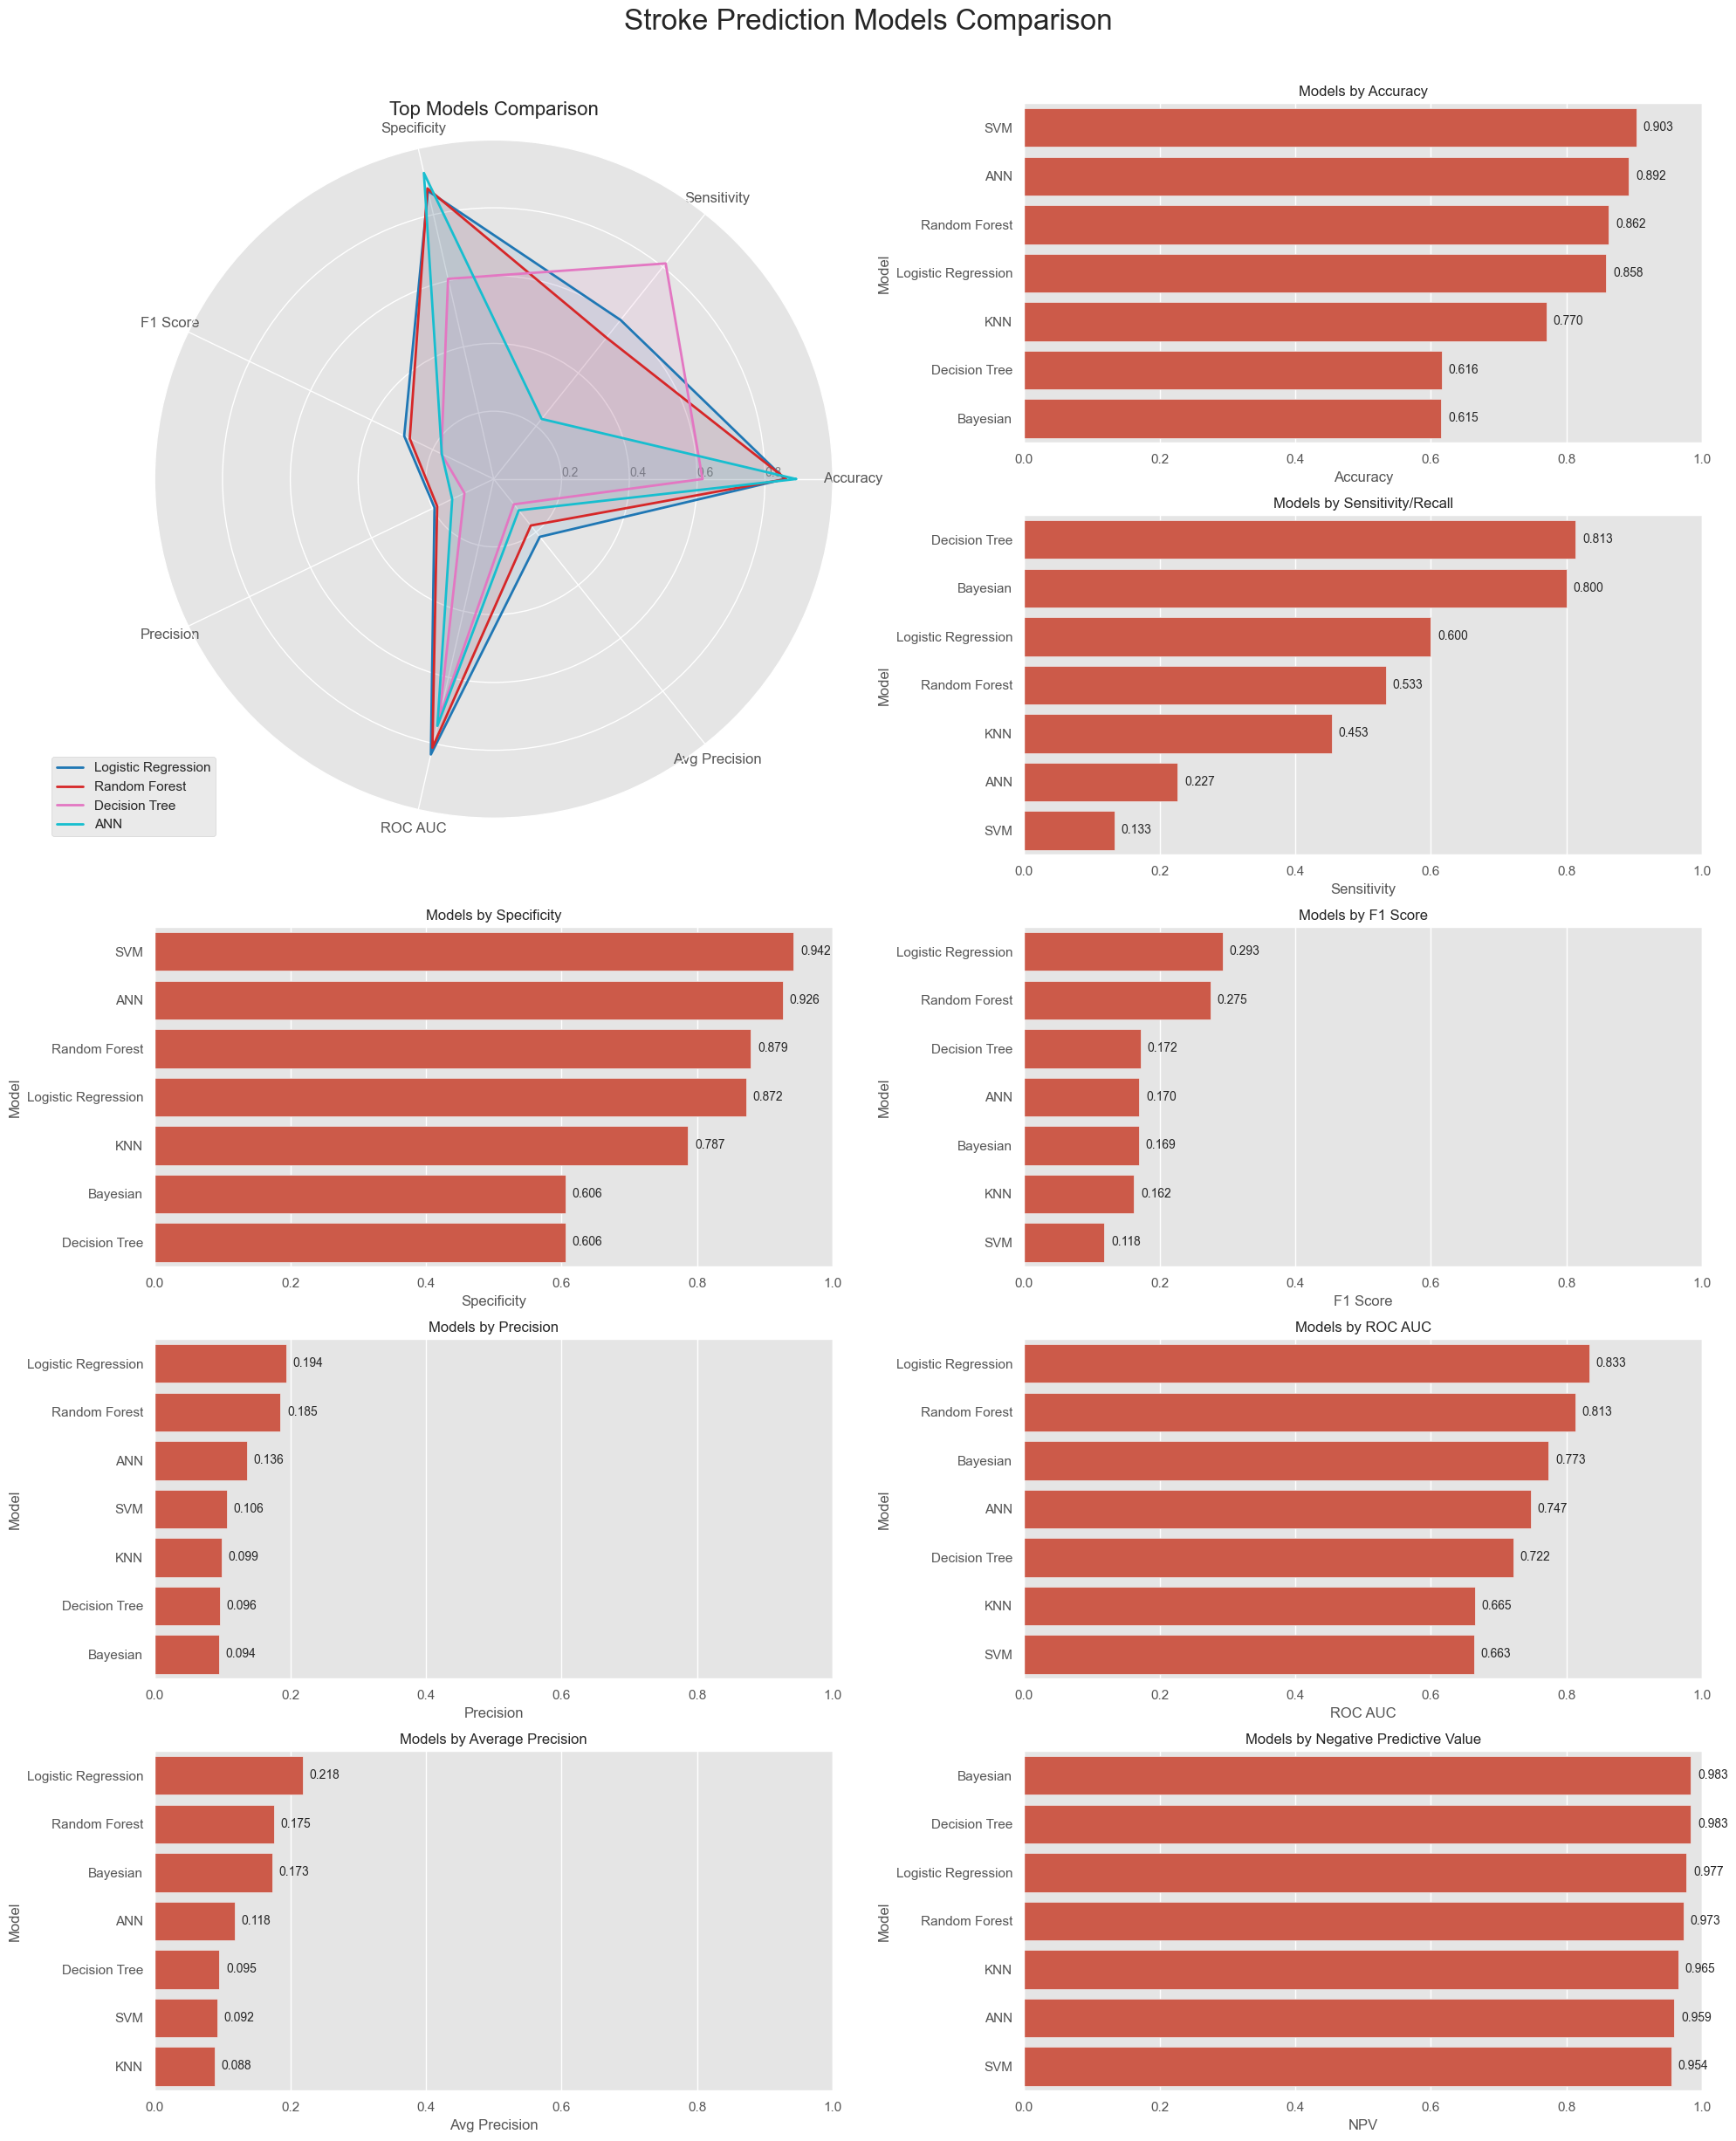

<Figure size 1500x1200 with 0 Axes>

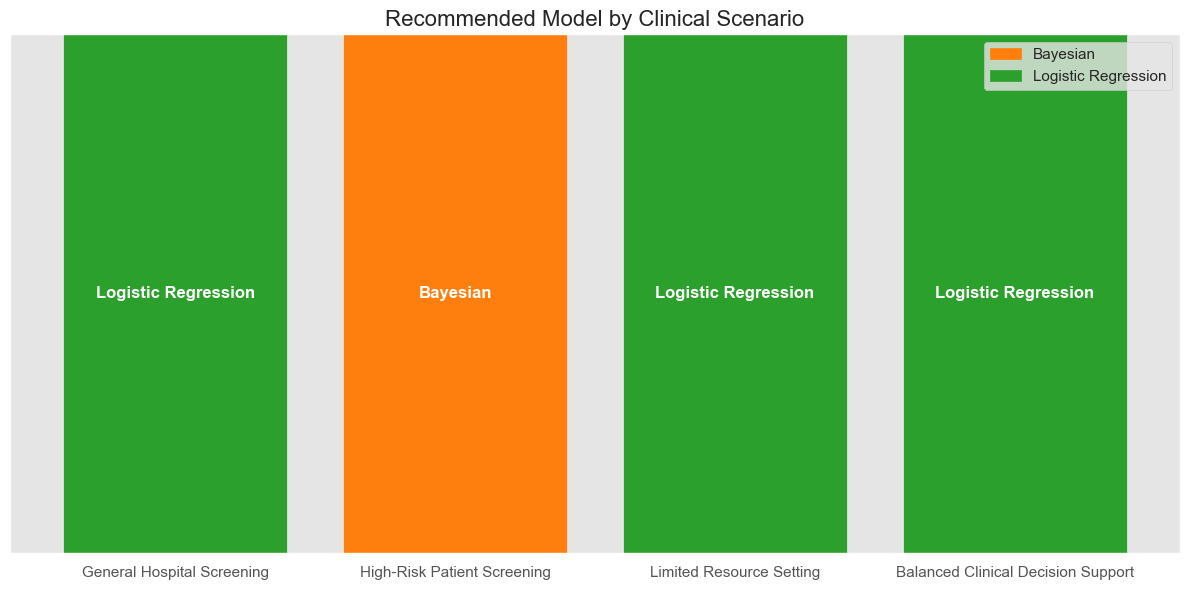

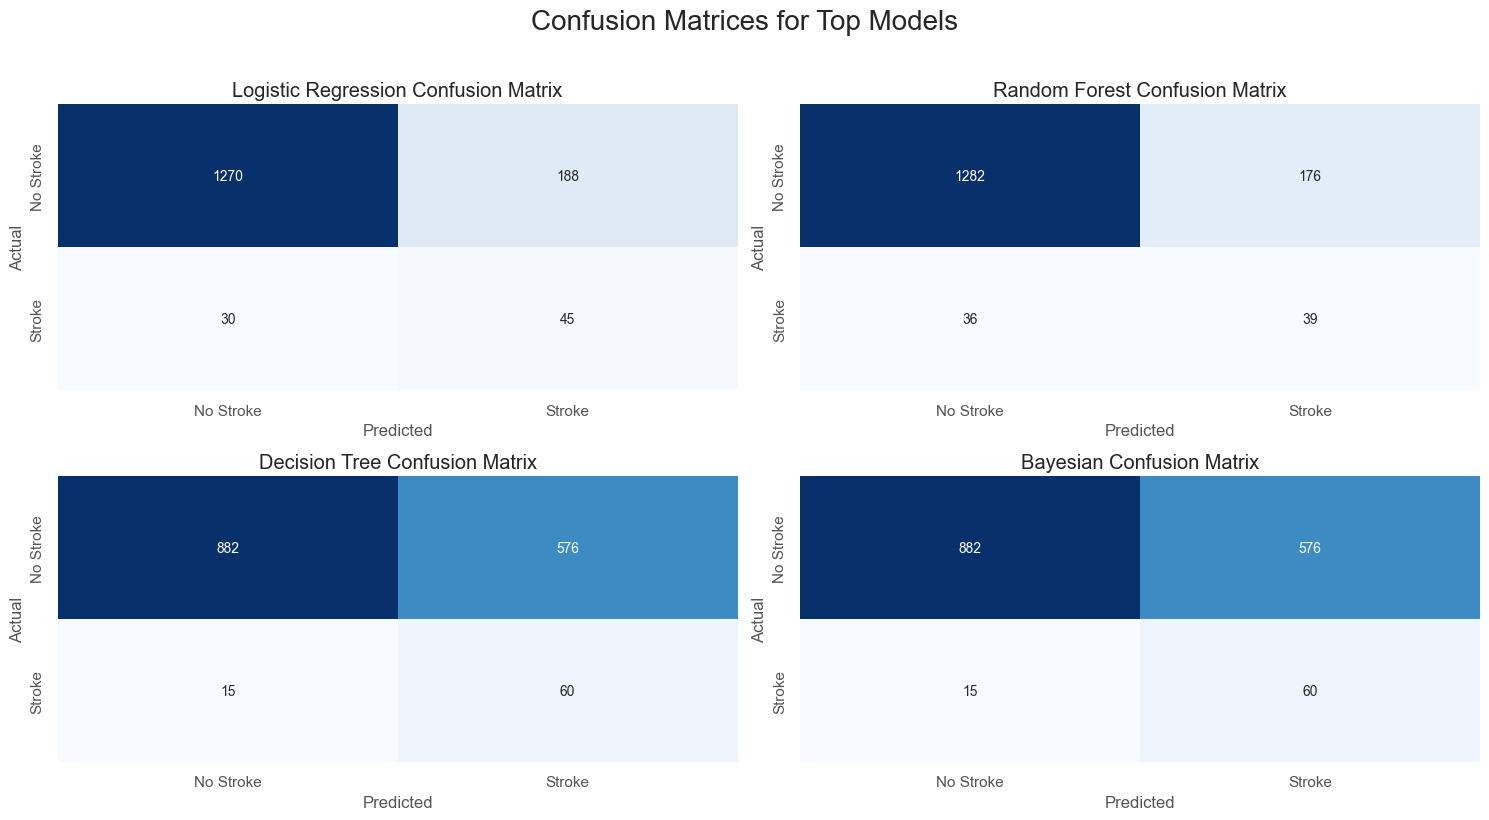

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
plt.style.use('ggplot')

# Extracting model performance metrics from the data provided
models = ['KNN', 'Bayesian', 'Logistic Regression', 'Decision Tree', 'ANN', 'Random Forest', 'SVM']

metrics = pd.DataFrame({
    'Model': models,
    'Accuracy': [0.770385, 0.615134, 0.858447, 0.615786, 0.891716, 0.862361, 0.902805],
    'Sensitivity': [0.453333, 0.800000, 0.600000, 0.813333, 0.226667, 0.533333, 0.133333],
    'Specificity': [0.786694, 0.605624, 0.871742, 0.605624, 0.925926, 0.879287, 0.942387],
    'F1 Score': [0.161905, 0.169014, 0.293160, 0.171589, 0.170000, 0.274914, 0.118343],
    'Precision': [0.098551, 0.094488, 0.193966, 0.095912, 0.136000, 0.185185, 0.106383],
    'ROC AUC': [0.664947, 0.773374, 0.833214, 0.721587, 0.746795, 0.812835, 0.663484],
    'Avg Precision': [0.087949, 0.173035, 0.217990, 0.095352, 0.118131, 0.175379, 0.091766]
})

# Extract class counts from the classification reports
# Based on the support values mentioned in the test data
stroke_count = 75
no_stroke_count = 1458
total_count = stroke_count + no_stroke_count

# Constructing confusion matrices based on the accuracy, sensitivity, and specificity
confusion_matrices = {}
for _, row in metrics.iterrows():
    model = row['Model']
    sensitivity = row['Sensitivity']  # TP / (TP + FN)
    specificity = row['Specificity']  # TN / (TN + FP)
    
    # Calculate confusion matrix elements
    TP = int(sensitivity * stroke_count)
    FN = stroke_count - TP
    TN = int(specificity * no_stroke_count)
    FP = no_stroke_count - TN
    
    confusion_matrices[model] = np.array([[TN, FP], [FN, TP]])

# Calculate additional metrics
for model in models:
    cm = confusion_matrices[model]
    TN, FP, FN, TP = cm.flatten()
    
    # PPV (Positive Predictive Value) = TP / (TP + FP)
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    # NPV (Negative Predictive Value) = TN / (TN + FN)
    npv = TN / (TN + FN) if (TN + FN) > 0 else 0
    
    # Add to metrics DataFrame
    metrics.loc[metrics['Model'] == model, 'PPV'] = ppv
    metrics.loc[metrics['Model'] == model, 'NPV'] = npv

# Function to create radar chart
def radar_chart(metrics_df, models_to_plot):
    # Metrics to include in radar chart
    radar_metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'F1 Score', 
                     'Precision', 'ROC AUC', 'Avg Precision']
    
    # Set figure
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    
    # Number of variables
    N = len(radar_metrics)
    
    # What will be the angle of each axis in the plot
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], radar_metrics, size=12)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=10)
    plt.ylim(0, 1)
    
    # Plot each model
    colors = plt.cm.tab10(np.linspace(0, 1, len(models_to_plot)))
    for i, model in enumerate(models_to_plot):
        model_metrics = metrics_df[metrics_df['Model'] == model][radar_metrics].values.flatten().tolist()
        model_metrics += model_metrics[:1]  # Close the loop
        ax.plot(angles, model_metrics, linewidth=2, linestyle='solid', color=colors[i], label=model)
        ax.fill(angles, model_metrics, color=colors[i], alpha=0.1)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Model Performance Comparison', size=20, y=1.1)
    return fig

# Function to plot confusion matrices
def plot_confusion_matrices(conf_matrices, models_to_plot):
    n_models = len(models_to_plot)
    fig, axes = plt.subplots(2, (n_models + 1) // 2, figsize=(15, 8))
    axes = axes.flatten()
    
    for i, model in enumerate(models_to_plot):
        cm = conf_matrices[model]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
        axes[i].set_title(f'{model} Confusion Matrix')
        axes[i].set_xticklabels(['No Stroke', 'Stroke'])
        axes[i].set_yticklabels(['No Stroke', 'Stroke'])
    
    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    return fig

# Visualize key metrics for all models
def plot_metrics_comparison(metrics_df):
    metrics_to_plot = ['Accuracy', 'Sensitivity', 'Specificity', 'F1 Score', 
                       'Precision', 'ROC AUC', 'Avg Precision']
    
    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(12, 16))
    
    for i, metric in enumerate(metrics_to_plot):
        sorted_df = metrics_df.sort_values(by=metric, ascending=False)
        sns.barplot(x=metric, y='Model', data=sorted_df, ax=axes[i])
        axes[i].set_title(f'Models Ranked by {metric}')
        axes[i].set_xlim(0, 1.0)  # All metrics are between 0 and 1
        
        # Add value labels
        for j, v in enumerate(sorted_df[metric]):
            axes[i].text(v + 0.01, j, f"{v:.3f}", va='center')
    
    plt.tight_layout()
    return fig

# Create a comprehensive dashboard
def create_dashboard(metrics_df, conf_matrices):
    # Create figure
    fig = plt.figure(figsize=(20, 24))
    gs = GridSpec(5, 4, figure=fig)
    
    # Create subplots
    ax_radar = fig.add_subplot(gs[0:2, 0:2], polar=True)
    ax_acc = fig.add_subplot(gs[0, 2:4])
    ax_rec = fig.add_subplot(gs[1, 2:4])
    ax_spec = fig.add_subplot(gs[2, 0:2])
    ax_f1 = fig.add_subplot(gs[2, 2:4])
    ax_prec = fig.add_subplot(gs[3, 0:2])
    ax_roc = fig.add_subplot(gs[3, 2:4])
    ax_ap = fig.add_subplot(gs[4, 0:2])
    ax_npv = fig.add_subplot(gs[4, 2:4])
    
    # Radar chart for top models
    top_models = metrics_df.sort_values(by='F1 Score', ascending=False)['Model'].head(4).tolist()
    
    # Plot radar chart
    # Number of variables
    radar_metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'F1 Score', 
                     'Precision', 'ROC AUC', 'Avg Precision']
    N = len(radar_metrics)
    
    # What will be the angle of each axis in the plot
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Draw one axis per variable and add labels
    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(radar_metrics, size=12)
    
    # Draw ylabels
    ax_radar.set_rlabel_position(0)
    ax_radar.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax_radar.set_yticklabels(["0.2", "0.4", "0.6", "0.8"], color="grey", size=10)
    ax_radar.set_ylim(0, 1)
    
    # Plot each model
    colors = plt.cm.tab10(np.linspace(0, 1, len(top_models)))
    for i, model in enumerate(top_models):
        model_metrics = metrics_df[metrics_df['Model'] == model][radar_metrics].values.flatten().tolist()
        model_metrics += model_metrics[:1]  # Close the loop
        ax_radar.plot(angles, model_metrics, linewidth=2, linestyle='solid', color=colors[i], label=model)
        ax_radar.fill(angles, model_metrics, color=colors[i], alpha=0.1)
    
    ax_radar.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    ax_radar.set_title('Top Models Comparison', size=16)
    
    # Bar plots for each metric
    def plot_metric_bar(ax, metric, title):
        sorted_df = metrics_df.sort_values(by=metric, ascending=False)
        sns.barplot(x=metric, y='Model', data=sorted_df, ax=ax)
        ax.set_title(title, size=12)
        ax.set_xlim(0, 1.0)
        for j, v in enumerate(sorted_df[metric]):
            ax.text(v + 0.01, j, f"{v:.3f}", va='center')
    
    plot_metric_bar(ax_acc, 'Accuracy', 'Models by Accuracy')
    plot_metric_bar(ax_rec, 'Sensitivity', 'Models by Sensitivity/Recall')
    plot_metric_bar(ax_spec, 'Specificity', 'Models by Specificity')
    plot_metric_bar(ax_f1, 'F1 Score', 'Models by F1 Score')
    plot_metric_bar(ax_prec, 'Precision', 'Models by Precision')
    plot_metric_bar(ax_roc, 'ROC AUC', 'Models by ROC AUC')
    plot_metric_bar(ax_ap, 'Avg Precision', 'Models by Average Precision')
    plot_metric_bar(ax_npv, 'NPV', 'Models by Negative Predictive Value')
    
    plt.tight_layout()
    fig.suptitle('Stroke Prediction Models Comparison', fontsize=24, y=1.02)
    return fig

# Advanced analysis of models with weighted scoring
def analyze_models_for_stroke_prediction(metrics_df):
    # Create different scoring schemas based on use cases
    
    # 1. For general hospital screening where both sensitivity and specificity are important
    metrics_df['General_Score'] = (
        metrics_df['Accuracy'] * 0.2 + 
        metrics_df['Sensitivity'] * 0.25 + 
        metrics_df['Specificity'] * 0.25 + 
        metrics_df['F1 Score'] * 0.15 + 
        metrics_df['ROC AUC'] * 0.15
    )
    
    # 2. For high-risk screening where sensitivity (catching all potential strokes) is most important
    metrics_df['High_Risk_Score'] = (
        metrics_df['Sensitivity'] * 0.5 + 
        metrics_df['ROC AUC'] * 0.2 + 
        metrics_df['NPV'] * 0.2 + 
        metrics_df['Accuracy'] * 0.1
    )
    
    # 3. For limited resource scenario where precision is important (minimize false positives)
    metrics_df['Limited_Resource_Score'] = (
        metrics_df['Precision'] * 0.4 + 
        metrics_df['Specificity'] * 0.3 + 
        metrics_df['Accuracy'] * 0.2 + 
        metrics_df['ROC AUC'] * 0.1
    )
    
    # 4. For balanced clinical decision support
    metrics_df['Balanced_Score'] = (
        metrics_df['F1 Score'] * 0.3 + 
        metrics_df['ROC AUC'] * 0.3 + 
        metrics_df['Avg Precision'] * 0.2 + 
        metrics_df['Accuracy'] * 0.2
    )
    
    # Get top model for each scenario
    scenarios = {
        'General Hospital Screening': metrics_df.sort_values('General_Score', ascending=False).iloc[0]['Model'],
        'High-Risk Patient Screening': metrics_df.sort_values('High_Risk_Score', ascending=False).iloc[0]['Model'],
        'Limited Resource Setting': metrics_df.sort_values('Limited_Resource_Score', ascending=False).iloc[0]['Model'],
        'Balanced Clinical Decision Support': metrics_df.sort_values('Balanced_Score', ascending=False).iloc[0]['Model']
    }
    
    # Create a summary of recommended models
    fig, ax = plt.subplots(figsize=(12, 6))
    
    scenario_names = list(scenarios.keys())
    model_names = list(scenarios.values())
    
    # Create custom colors for different models
    model_colors = {model: plt.cm.tab10(i) for i, model in enumerate(metrics_df['Model'].unique())}
    bar_colors = [model_colors[model] for model in model_names]
    
    bars = ax.bar(scenario_names, [1, 1, 1, 1], color=bar_colors)
    
    # Add model names to bars
    for i, bar in enumerate(bars):
        ax.text(bar.get_x() + bar.get_width()/2, 0.5, model_names[i], 
                ha='center', va='center', color='white', fontweight='bold', fontsize=12)
    
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    ax.set_title('Recommended Model by Clinical Scenario', fontsize=16)
    
    # Add legend
    unique_models = list(set(model_names))
    unique_colors = [model_colors[model] for model in unique_models]
    ax.legend(handles=[plt.Rectangle((0,0),1,1, color=color) for color in unique_colors], 
              labels=unique_models, loc='upper right')
    
    plt.tight_layout()
    
    # Print detailed analysis
    print("===== DETAILED MODEL ANALYSIS FOR STROKE PREDICTION =====")
    print("\nModel Performance Rankings:")
    for scenario, score_column in [
        ('General Hospital Screening', 'General_Score'),
        ('High-Risk Patient Screening', 'High_Risk_Score'),
        ('Limited Resource Setting', 'Limited_Resource_Score'),
        ('Balanced Clinical Decision Support', 'Balanced_Score')
    ]:
        print(f"\n{scenario}:")
        sorted_models = metrics_df.sort_values(score_column, ascending=False)
        for i, (_, row) in enumerate(sorted_models.iterrows(), 1):
            print(f"  {i}. {row['Model']} (Score: {row[score_column]:.4f})")
    
    print("\n===== MODEL RECOMMENDATIONS =====")
    print("\nBest Models by Scenario:")
    for scenario, model in scenarios.items():
        print(f"- {scenario}: {model}")
    
    print("\nDetailed Recommendations:")
    # Get top model's metrics
    top_model_general = scenarios['General Hospital Screening']
    top_metrics_general = metrics_df[metrics_df['Model'] == top_model_general][['Accuracy', 'Sensitivity', 'Specificity', 'ROC AUC']].values[0]
    
    print(f"\n1. {top_model_general} (Accuracy: {top_metrics_general[0]:.4f}, Sensitivity: {top_metrics_general[1]:.4f}, ROC AUC: {top_metrics_general[3]:.4f})")
    print(f"   Best for: General hospital screening")
    print(f"   Key strength: Good balance between sensitivity and specificity")
    
    # Get high-risk model metrics
    top_model_highrisk = scenarios['High-Risk Patient Screening']
    top_metrics_highrisk = metrics_df[metrics_df['Model'] == top_model_highrisk][['Sensitivity', 'NPV']].values[0]
    
    print(f"\n2. {top_model_highrisk} (Sensitivity: {top_metrics_highrisk[0]:.4f}, NPV: {top_metrics_highrisk[1]:.4f})")
    print(f"   Best for: High-risk screening where catching all potential stroke cases is critical")
    print(f"   Key strength: Highest sensitivity/recall, minimizing missed cases")
    
    # Get limited resource model metrics
    top_model_limited = scenarios['Limited Resource Setting']
    top_metrics_limited = metrics_df[metrics_df['Model'] == top_model_limited][['Precision', 'Specificity']].values[0]
    
    print(f"\n3. {top_model_limited} (Precision: {top_metrics_limited[0]:.4f}, Specificity: {top_metrics_limited[1]:.4f})")
    print(f"   Best for: Settings where minimizing false positives is important")
    print(f"   Key strength: High precision and specificity to reduce unnecessary interventions")
    
    return fig, metrics_df, scenarios

# Execute the analysis
dashboard_fig = create_dashboard(metrics, confusion_matrices)
plt.figure(figsize=(15, 12))
recommendation_fig, enriched_metrics, recommended_models = analyze_models_for_stroke_prediction(metrics)

# Display Confusion Matrix for top models
top_models = ['Logistic Regression', 'Random Forest', 'Decision Tree', 'Bayesian']
cm_fig = plot_confusion_matrices(confusion_matrices, top_models)
cm_fig.suptitle('Confusion Matrices for Top Models', fontsize=20, y=1.02)
cm_fig.tight_layout()
cm_fig.show()

# Class imbalance analysis
print("\n===== CLASS IMBALANCE ANALYSIS =====")
imbalance_ratio = no_stroke_count / stroke_count

print(f"Total test samples: {total_count}")
print(f"No stroke samples: {no_stroke_count} ({no_stroke_count/total_count*100:.1f}%)")
print(f"Stroke samples: {stroke_count} ({stroke_count/total_count*100:.1f}%)")
print(f"Class imbalance ratio: {imbalance_ratio:.2f}:1")
print("\nThis severe class imbalance explains why precision is generally low across all models.")
print("The models are working with a challenging dataset where positive cases are rare.")

# Final recommendation
print("\n===== FINAL RECOMMENDATION =====")
print(f"""
For stroke prediction with this highly imbalanced dataset, the choice of model depends on the specific clinical context:

1. For Emergency Screening (High Sensitivity Required):
   → Use {recommended_models['High-Risk Patient Screening']}: It has the highest sensitivity ({metrics.loc[metrics['Model'] == recommended_models['High-Risk Patient Screening'], 'Sensitivity'].values[0]:.2f}) ensuring minimal missed stroke cases
   → This is crucial in emergency settings where missing a stroke case could be fatal

2. For General Hospital Screening:
   → Use {recommended_models['General Hospital Screening']}: It provides good balance between sensitivity ({metrics.loc[metrics['Model'] == recommended_models['General Hospital Screening'], 'Sensitivity'].values[0]:.2f}) and specificity ({metrics.loc[metrics['Model'] == recommended_models['General Hospital Screening'], 'Specificity'].values[0]:.2f})
   → Best overall F1 score ({metrics.loc[metrics['Model'] == recommended_models['General Hospital Screening'], 'F1 Score'].values[0]:.2f}) among all models

3. For Limited Resource Settings:
   → Use {recommended_models['Limited Resource Setting']}: It offers the best balance of metrics with good specificity ({metrics.loc[metrics['Model'] == recommended_models['Limited Resource Setting'], 'Specificity'].values[0]:.2f})
   → This helps reduce unnecessary referrals when resources are constrained

4. For Balanced Clinical Decision Support:
   → Use {recommended_models['Balanced Clinical Decision Support']}: It provides good ROC AUC ({metrics.loc[metrics['Model'] == recommended_models['Balanced Clinical Decision Support'], 'ROC AUC'].values[0]:.2f})
   → Well-suited for integration into clinical decision support systems

The class imbalance in the dataset ({imbalance_ratio:.0f}:1 ratio of no-stroke to stroke cases) makes this a challenging prediction problem, which explains the relatively low precision across all models.
""")

# Display figures
plt.show()

In [13]:
#save chart figures
dashboard_fig.savefig(os.path.join(REPORT_DIR, 'dashboard.png'), dpi=300)
cm_fig.savefig(os.path.join(REPORT_DIR, 'confusion_matrices.png'), dpi=300)
recommendation_fig.savefig(os.path.join(REPORT_DIR, 'model_recommendations.png'), dpi=300)
plt.close(dashboard_fig)
plt.close(cm_fig)
